<a href="https://colab.research.google.com/github/prajeshatm/hello/blob/main/HamoyeStageDTaponProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AMAZON DEFORESTATION

In [9]:
pip install keras.applications

     |████████████████████████████████| 50 kB 3.1 MB/s 


In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
!pip install keras.applications
from keras.applications import *
from keras.optimizers import *


In [16]:
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [17]:
# load csv
df_train = pd.read_csv('train_v2_d.csv')
df_train.sample(5)

,image_name,tags
31572,train_31572,clear primary water
12665,train_12665,partly_cloudy primary
27551,train_27551,agriculture partly_cloudy primary road
22339,train_22339,clear primary
14993,train_14993,clear primary


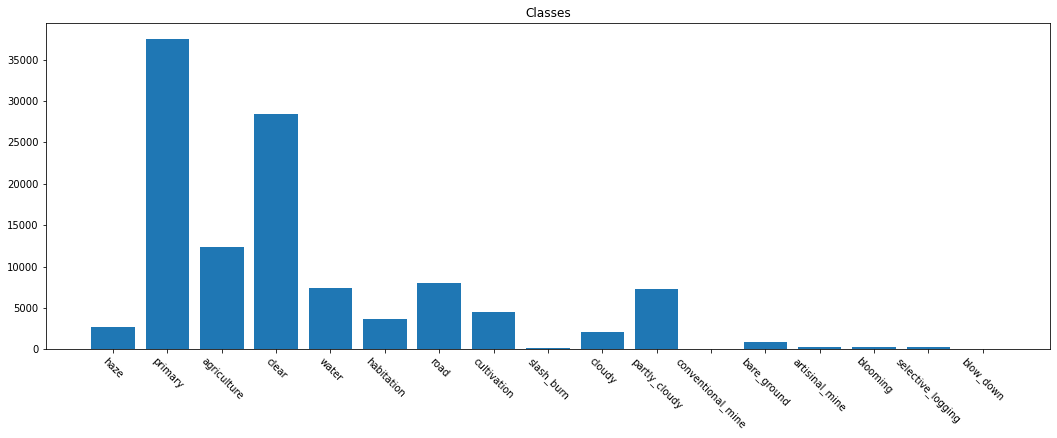

In [18]:
# numbers of tags and their names
counts = {}
splitted_tags = df_train['tags'].map(lambda x: x.split(' '))
for labels in splitted_tags.values:
    for label in labels:
        counts[label] = counts[label] + 1  if label in counts else 0

plt.figure(figsize=(18, 6))
plt.title('Classes')
idxs = range(len(counts.values()))
plt.xticks(idxs, counts.keys(), rotation=-45)
plt.bar(idxs, counts.values());

In [ ]:
# random images
plt.rc('axes', grid = True)

_, ax = plt.subplots(1, 3, figsize=(20, 20))
random_img = np.random.randint(0,len(df_train) - 3)
for i , (file, label) in enumerate(df_train[random_img:random_img + 3].values):
    img = cv2.imread('input/train-jpg/{}.jpg'.format(file))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('{} - {}'.format(file, label))
    
plt.show()

In [ ]:
# load data
all_labels = splitted_tags.values
labels = list(set([y for x in all_labels for y in x]))

def load_data(df_train, labels, resize):
    X_train = []
    y_train = []

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in df_train.values:
        img = cv2.imread('input/train-jpg/{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 

        X_train.append(cv2.resize(img,resize))
        y_train.append(targets)
        
    y_train = np.array(y_train, np.uint8)
    X_train = np.array(X_train, np.float16) / 255.

    return X_train, y_train
X, y = load_data(df_train, labels,resize=(128, 128))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = int(time.time()))

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(17, activation='sigmoid') 
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta_score_K])
model.summary()

In [ ]:
model_fit = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val)
)